# Gensim Topic Modeling

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Spacy
import spacy

# Scipy
import scipy.sparse

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# Gensim
from gensim import matutils
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel

# NLTK
from nltk.corpus import stopwords

# Pyldavis
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

#### Color Palette

In [2]:
blush = '#F7D1CD'
pink = '#E8C2CA'
light_purple = '#D1B3C4'
medium_purple = '#B392AC'
dark_purple = '#B392AC'
warm_grey = '#8E9AAF'

## Read-In Data

In [3]:
health = pd.read_csv('../data/womens_health_preprocessed.csv', lineterminator='\n')
print(f'Health: {health.shape}')
obsgyn = pd.read_csv('../data/fertility_and_pregnancy_preprocessed.csv')
print(f'ObsGyn: {obsgyn.shape}')
pospar = pd.read_csv('../data/postpartum_preprocessed.csv')
print(f'Pospar: {pospar.shape}')

Health: (30616, 7)
ObsGyn: (92943, 7)
Pospar: (49094, 7)


## Define Stop Words

In [4]:
def add_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.add(word)
        
def remove_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.remove(word)

In [5]:
# spaCy
nlp = spacy.load('en_core_web_sm')
stop_words_spacy = set(nlp.Defaults.stop_words)

# nltk
stop_words_nltk = set(stopwords.words('english'))

# full list of stop words
full_stop_words = stop_words_spacy.union(stop_words_nltk)

words_to_add = ['like', 'know', 'want', 'feel', 'going', 'think', 'reddit', 'imgur', 'pron', 'officially', 'story', 'month', 'week', 'time', 'day', 'year', 'delete', 'saturday', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'subreddit']

add_stop_words(words_to_add, full_stop_words)
remove_stop_words(['not'], full_stop_words)

## Create Document Term Matrix From Corpus

#### Function

In [6]:
def build_tvec(df, column, stop_words = full_stop_words):
    tvec = TfidfVectorizer(max_df = 0.98, min_df = 0.005, ngram_range = (1,2), stop_words = stop_words)
    dtm = tvec.fit_transform(df[column])
    return tvec, dtm

#### Create Document Term Matrix

In [7]:
# Vectorizer, dtm are outputed from build_tvec

health_vectorizer, health_dtm = build_tvec(health, 'lemma_text')
obsgyn_vectorizer, obsgyn_dtm = build_tvec(obsgyn, 'lemma_text')
pospar_vectorizer, pospar_dtm = build_tvec(pospar, 'lemma_text')

#### Transform Document Term Matrix into a Term Document Matrix that can be recognized by Gensim

**Note**: Code for these steps was modified from [A Dash of Data](https://github.com/adashofdata/nlp-in-python-tutorial) by Alice Zhao

In [8]:
def create_tdm(dtm):
    tdm = dtm.transpose()
    return tdm

In [9]:
def tdm_to_gensim_corpus(tdm):
    sparse = scipy.sparse.csr_matrix(tdm) # Create a compressed sparse row matrix
    corpus = matutils.Sparse2Corpus(tdm) # Create a corpus from sparse matrix
    return corpus

In [10]:
def prepare_dtm_for_gensim(dtm):
    tdm = create_tdm(dtm)
    corpus = tdm_to_gensim_corpus(tdm)
    return corpus

In [11]:
health_corpus = prepare_dtm_for_gensim(health_dtm)
obsgyn_corpus = prepare_dtm_for_gensim(obsgyn_dtm)
pospar_corpus = prepare_dtm_for_gensim(pospar_dtm)

## Define Vocabulary Dictionary from Vectorizer

In [12]:
def create_vocab_dictionary(vectorizer):
    vocab_dictionary = dict((v,k) for k,v in vectorizer.vocabulary_.items())
    return vocab_dictionary

In [13]:
health_vocabulary = create_vocab_dictionary(health_vectorizer)
obsgyn_vocabulary = create_vocab_dictionary(obsgyn_vectorizer)
pospar_vocabulary = create_vocab_dictionary(pospar_vectorizer)

## Topic Modeling with Latent Dirichlet Allocation (LDA)

### Build LDA Models

#### Functions

In [14]:
def build_gensim_lda(corpus, n_topics, vocabulary, n_passes):
    lda = LdaModel(corpus = corpus, num_topics = n_topics, id2word = vocabulary, passes = n_passes, decay = 0.7, offset = 10, random_state = 2020)
    return lda

In [15]:
def build_gensim_coherence_model(model, corpus, dictionary):
    coherence = CoherenceModel(model=model, corpus = corpus, dictionary = dictionary, coherence = 'u_mass')
    return round(coherence.get_coherence(), 3)

In [16]:
def get_topic_terms(model, n_topics, n_words):
    return model.print_topics(num_topics = n_topics, num_words = n_words)

In [17]:
# Function Written By Selva Prabhakaran
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def assign_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]): # iterate over transformed corpus to get topic probabilities for document
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    sent_topics_df.columns = ['Dominant_Topic', 'Percent_Dominant_Topic', 'Keywords', 'Original_Text']
    
    return sent_topics_df

##### Examine Topic Composition for Each Number of Topics

Because each model that was built in the grid search was stored in a model dictionary where the number of topics was the key, we can easily access the model to explore the topics that were created. 

For example, for the model with 6 topics, the following code can be used to retrieve the top 10 terms for each of the 6 topics.

```python
health_lda_6 = health_lda_models[6]

get_topic_terms(health_lda_6, 6, 10)
```
This was done for each several numbers of topics. At each step of the way, the topic clusters were evaluated to determine if the clusters made sense and if any loss in cohesion was offset by a gain in knowledge about a woman's health concern. After this process, 15 topics was determined to be the optimal number of topics for the general women's health data. Therefore, a new model was fit with the identified number of topics. To ensure, optimal allocation of topics, the model was allowed to run for 100 iterations. 

#### Build an LDA Model for General Women's Health Data and Evaluate on Coherence

In [18]:
health_lda_model = build_gensim_lda(health_corpus, 
                               n_topics = 12, 
                               vocabulary = health_vocabulary, 
                               n_passes = 50)

In [19]:
build_gensim_coherence_model(health_lda_model, corpus = health_corpus, dictionary = health_vocabulary)

-2.334

The LDA model with 12 topics has a coherence score of -2.3. Given that UMass coherence scores can range from 0 (best) to -14 (worst), this is a fairly good score and indicates that words within a topic are similar.

#### Explore Top Terms for Each Topic
**Note:** Top terms are determined based on their probability for occuring in the topic.

For each topic, we are able to view the terms with the highest probability of appearing in the topic. An example is shown in the cell below:

In [113]:
get_topic_terms(health_lda_model, 1, 5) # Will show the words with the highest probability for topic chosen at random

[(5,
  '0.098*"eat" + 0.051*"food" + 0.039*"self esteem" + 0.039*"esteem" + 0.035*"diet"')]

Above, we see a list containing a tuple. The first item in the tuple is the topic number, and the second item is a string that contains the probability of a word appearing in the topic and the word itself. I have chosen to display only the top five words

We can save a list of of the topics and top terms to a list (below), and use indexing to explore the topics and terms in this list. This exploration allows us to derive meaning from the topics. 

In [20]:
health_lda_topic_terms = get_topic_terms(health_lda_model, 12, 20)

In the table below, the twelve topics that were indentified in the General Women's Health data set are presented. As seen below, there were three topic clusters that were not related to women's health.


<h4 align = center> Clusters Related to Health Concerns </h4>

| Cluster Number| Name| Top 5 Terms |
|:-:|:-:|:-:|
|0|Infections (Yeast Infection and Bacterial Vaginosis)|infection, yeast, yeast infection, discharge, smell|
|1|Feminine Hygiene Products| tampon, cup, pad, menstrual, menstrual cup|
|4| Pains| pain, period, cyst, cramp, doctor|
|5| Body Image and Self-Esteem| eat, food, self esteem, esteem, diet|
|6| Birth Control (Intrauterine Devices and Implants)| IUD (intrauterine device), control, birth, birth control, pill|
|7| General Gynecological Health| vagina, breast, sex, pap, hurt|
|8| Infections (Urinary Tract Infections)| UTI (urinary tract infection), pee, drink, antibiotic, orgasm|
|9| Birth Control (Oral Contraceptives and Condoms)| pill, birth control, birth, control, pack|
|10| Menstrual Cycle and Abnormalities| period, bleed, start, test, pregnancy|

<h4 align = center> Clusters Not Related to Health Concerns </h4>

| Cluster Number| Name| Top 5 Terms |
:-:|:-:|:-:
2| Social Relationships| friend, guy, people, work, thing
3| Hair and Depilation| hair, shave, skin, look, wax
11| Fashion| wear, dress, bra, look, buy




From this data set, the following women's health concerns emerged:

**Infections (Yeast Infections and Bacterial Vaginosis)**: The top five terms for this topic were "infection", "yeast", "yeast infection", "discharge", and "smell". However, other words that were seen in this topic cluster include mentions of "BV" (bacterial vaginosis), words related to anatomical location ("vagina", "vaginal"), and other vaginal symptoms ("itch", "itching", "symptom").

**Infections (Urinary Tract Infections)**: The top five terms for this topic were "UTI" (urinary tract infection), "pee", "drink", "antibiotic", and "orgasm". Other words related to urinary tract infections included descriptions of symptoms: "burn", "urine", "bladder", "sensation". The words "sex" and "orgasm" were also included in this cluster. Given that sexual intercourse can be a source of bacteria that might lead to a urinary tract infection, it is possible that these terms were included in posts as a possible cause of the infection.

**Menstrual Cycle and Abnormalities**: The top five terms for this topic were "period", "bleed", "start", "test" and "pregnancy". Words such as "period", "bleed", "start", "normal", "cycle", and "blood" suggest that the topic is about the menstrual cycle. Words such as "test", "pregnancy", "pregnant", "late", "spot", "pill", and "light" suggest that this topic might describe menstrual cycle abnormalities, such as a late or missed period, possibility of pregnancy, spotting, or a lighter than usual period.

**Feminine Hygiene Products**: The top five words for this topic were "tampon", "cup", "pad", "menstrual", and "menstrual cup". All of these words are commonly used feminine hygiene products used during a woman's period. Additionally, words that suggest advice on how or when to use these products emerged, including "use", "try", "insert", and "wear". Events which might require a feminine hygiene product also emerged, including "abortion" and "period".

**General Gynecological Health**: The top five words for this topic were "vagina", "breast", "sex", "pap" (pap smear), and "hurt". This cluster contained words related to the routine gynecological exam, including "pap", "smear", "pap smear", and "doctor". This topic also seemed to capture concerns about possible tumors ("lump", "bump") and general pains ("hurt", "pain", "painful"). All of the concerns in this topic are things that would be discussed at an annual gynecological exam.

**Pains**: The top five words for this topic were "pain", "period", "cyst", "cramp", "doctor". This topic seemed to capture common pains that women experience, including period pain ("period", "cramp", "pelvic"), as well as pains related to ovarian cysts ("ovary", "ovarian", "cyst", "pelvic", "right"). The term "ultrasound" suggests that this topic might also include procedures used to detect ovarian cysts.

**Birth Control (Intrauterine Devices and Implants)**: The top five words for this topic were "IUD" (intrauterine device), "control", "birth", "birth control", an "pill". Although the posts in this topic were likely related to birth control, several words suggest that the questions were about alternatives to oral contraceptives. The words "implant" and "Nexplanon" (a type of implant) suggest birth control implants, while the words "IUD", "Mirena" (a brand of IUD), "copper", and "hormonal" could be discussing hormonal and non-hormonal versions of IUDs. It appears that this topic might also include posts about experiences with these birth control methods, including possible effects on "acne" and "mood".

**Birth Control (Oral Contraceptives and Condoms)**: The top five words for this topic were "pill", "birth control", "birth", "control", and "pack". Several of these words, including the top five, suggest that this topic includes posts about oral contraceptives. Other words that suggest oral contraceptives are "control pill", "plan" (maybe Plan B), "placebo", "bc" (birth control), and "miss" (possibly a missed pill). "Condom" is also the 6th most common word, which suggests that condoms as a form of birth control might also be included in this topic.

**Body Image and Self-Esteem**: The top five words for this category were "eat", "food", "self esteem", "esteem", and "diet". Several words suggest that this topic might include posts about body image and self-esteem, including "eat", "food", "self esteem", "esteem", "diet", "vitamin", "belly", "insecure", "supplement", and "cope". 

#### Explore How Topics Relate to Original Data

For each post in our data set, we are able to assign it to a topic. Each post was assigned to the topic with the highest probability.

##### Rename Topic Numbers and Assign Topics

In [83]:
health_topic_df = assign_topics_sentences(health_lda_model, health_corpus, health['total_text'])

In [85]:
health_topic_df['Dominant_Topic'] = health_topic_df['Dominant_Topic'].map({0.0: 'Infections (Yeast Infection and Bacterial Vaginosis)',
                                                    1.0: 'Feminine Hygiene Products',
                                                    2.0: 'Social Relationships',
                                                    3.0: 'Hair and Depilation',
                                                    4.0: 'Pains',
                                                    5.0: 'Body Image and Self-Esteem',
                                                    6.0: 'Birth Control (Intrauterine Devices and Implants',
                                                    7.0: 'General Gynecological Health',
                                                    8.0: 'Infections (Urinary Tract Infections)',
                                                    9.0: 'Birth Control (Oral Contraceptives and Condoms)',
                                                    10.0: 'Menstrual Cycle and Abnormalities',
                                                    11.0: 'Fashion'})

In [86]:
health_topic_df.head()

,Dominant_Topic,Percent_Dominant_Topic,Keywords,Original_Text
0,Infections (Yeast Infection and Bacterial Vagi...,0.8935,"infection, yeast, yeast infection, discharge, ...",Been to the clinic twice and they don’t know w...
1,Menstrual Cycle and Abnormalities,0.8745,"period, bleed, start, test, pregnancy, normal,...",Period going on for days today. Help!! Hi guy...
2,Birth Control (Intrauterine Devices and Implants,0.6107,"iud, control, birth, birth control, pill, expe...",Question about birth control - advice apprecia...
3,Infections (Yeast Infection and Bacterial Vagi...,0.8151,"infection, yeast, yeast infection, discharge, ...",Yeast infection vs. Cytolytic Vaginosis? Hi ev...
4,Pains,0.4503,"pain, period, cyst, cramp, doctor, bad, ultras...",Virgin concerned about transvaginal ultrasound...


In [138]:
def plot_topics_in_corpus(df, column, color, title = None, x_label = None, ):
    plt.figure(figsize = (15, 8))
    round(df[column].value_counts(normalize = True) * 100, 2).sort_values(ascending = True).plot.barh(color = color, ec = 'k');
    plt.title(title, fontdict = {'fontsize': 20}, pad = 18)
    plt.xlabel(x_label, fontdict = {'fontsize': 15}, labelpad = 10)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.tight_layout();

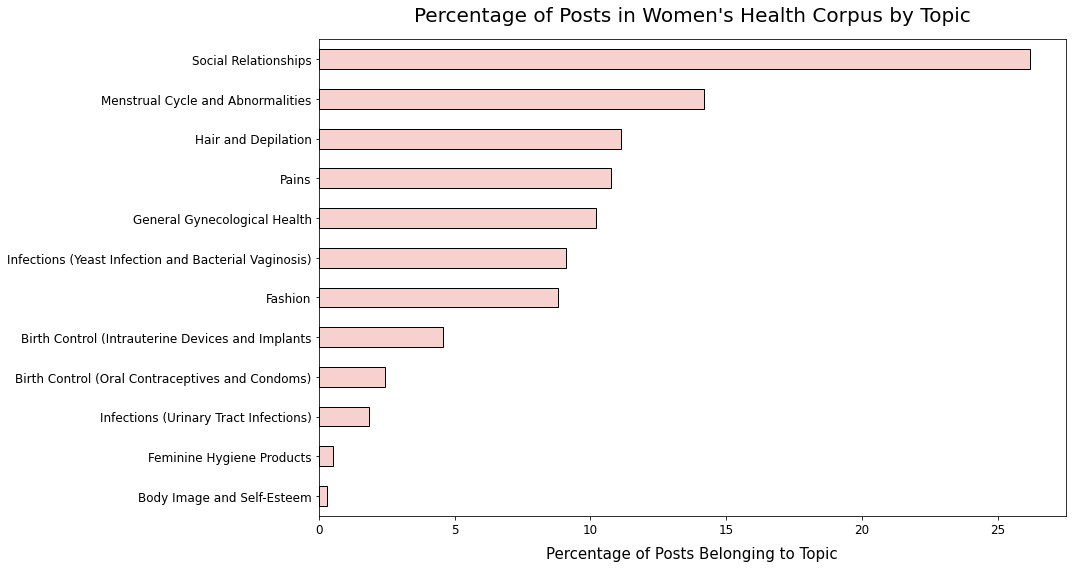

In [141]:
plot_topics_in_corpus(health_topic_df, 
                      'Dominant_Topic', 
                       blush,
                       title = 'Percentage of Posts in Women\'s Health Corpus by Topic',
                       x_label = 'Percentage of Posts Belonging to Topic')

##### Identify Most Representative Text for Each Topic

In [100]:
def filter_df_by_topic(df, column, topic):
    filtered_df = df[df[column] == topic]
    filtered_df = filter_df.sort_values(by = "Percent_Dominant_Topic", ascending = False)
    return filtered_df

In [92]:
social_relationships = filter_df_by_topic(health_topic_df, 'Dominant_Topic', 'Social Relationships')
# social_relationships = social_relationships.sort_values(by = 'Percent_Dominant_Topic', ascending = False)

In [95]:
menstrual = filter_df_by_topic(health_topic_df, 'Dominant_Topic', 'Menstrual Cycle and Abnormalities')


#### Fertility and Pregnancy

In [102]:
obsgyn_lda_model = build_gensim_lda(obsgyn_corpus, 
                               n_topics = 10, 
                               vocabulary = obsgyn_vocabulary, 
                               n_passes = 50)

In [103]:
build_gensim_coherence_model(obsgyn_lda_model, corpus = obsgyn_corpus, dictionary = obsgyn_vocabulary)

-1.961

In [135]:
obsgyn_lda_topic_terms = get_topic_terms(obsgyn_lda_model, 10, 30)


<h4 align = center> Clusters Related to Fertility and Pregnancy Concerns </h4>

| Cluster Number| Name| Top 5 Terms |
|:-:|:-:|:-:|
|0| Pregnancy Life Changes| birth, work, baby, hospital, leave
|1| Pregnancy Announcement| baby, pregnant, tell, husband, family
|2| Labor and Delivery| contraction, labor, cm (centimeters), induction, induce
|3| Nausea and Vomiting During Pregancy| eat, sleep, food, nausea, morning
|4| Determination of Pregnancy| test, period, pregnancy, pregnant, positive
|6| Fertility| cycle, ovulation, TTC (trying to conceive), try, ovulate
|8| Obstetrics Appointments| ultrasound, doctor, blood, baby, appointment
|9| Pregnancy Pains and Body Changes| pain, belly, baby, weight, kick

<h4 align = center> Clusters Not Related to Health Concerns </h4>

| Cluster Number| Name| Top 5 Terms |
|:-:|:-:|:-:|
|5| Recommendations for Products|maternity, pregnancy, pregnant, recommendation, bra
|7| Items for the New Baby| baby, buy, shower, nursey, diaper

From this data set, the following women's health concerns emerged:

* **Pregnancy Life Changes**: The top five terms for this topic are "birth", "work", "baby", "hospital", and "leave". Overall, this topic seems to be clustered around preparing for the experience of pregnancy and labor and the associated life changes that come with this major life change. Terms related to pregnancy and delivery are: "birth", "baby", "hospital", "csection" (C-Section), "pregnant", "pregnancy", "delivery", "doctor", and "labor". Terms indicative of life changes include: "work", "leave", "job", "plan", and "insurance".

* **Pregnancy Announcement**: The top five terms in this topic are: "baby", "pregnant", "tell", "husband", and "family". These terms, along with "people", "friend", "mom", "work", and "excited", suggest that posts in this topic might be about announcing the pregnancy to family members, friends, and the place of employment. 

* **Labor and Delivery**: The top five terms for this topic are "contraction", "labor", "cm" (centimeters), "induction", and "induce", suggesting that this topic is related to labor and delivery of the baby. Other terms in this topic that are related to the process of labor and delivery include: "epidural", "water", "pain", "dilate", "push", "cervix", "hospital", "labour", "braxton" (Braxton Hicks contractions), "water break", "hicks", and "braxton hicks". 

* **Nausea and Vomiting During Pregnancy and Sleep Difficulties**: The top five terms in this topic are: "eat", "sleep", "food", "nausea", and "morning". Many of the top terms in this topic are related to nausea and vomiting during pregnancy (NVP), as well as possible sleeping difficulties during pregnancy. Terms related to NVP include: "eat", "food", "nausea", "morning", "sickness", "morning sickness", "sick", "drink", "throw", "smell", "nauseous", an "hungry". Terms related to possible sleep difficulties include: "sleep", "night", "wake", "tired", and "bed".

* **Determination of Pregnancy**: The top five terms in this topic are "test", "period", "pregnancy", "pregnant", and "positive". Many of the top terms in this topic are related to pregnancy tests and determining if a woman is pregnant. Terms about pregnancy tests include: "test", "positive", "pregnancy test", "negative", and "line" (possible line on pregnancy test). Terms about determining pregnancy status are related to abnormal period symptoms ("period", "bleed", "spot", "late", "blood", "light", "cramping", "brown", "discharge", and "bleeding"), as a late period, cramping, spotting, and discharge can all occur in early pregnancy. The words "miscarriage", "cramping", and "bleeding" could also indicate that this topic also captures posts about miscarriage. 

* **Fertility**: The top five terms in this topic are "cycle", "ovulation", "TTC" (trying to conceive), "try", and "ovulate". Overall, the top terms in this topic appear to be related to fertility and ovulation. Top terms can be grouped based on *hormones* ["progesterone", "clomid" (an estrogen modulator), and "LH" (lutenizing hormone)], *ovulation tracking* ["cycle", "ovulation", "ovulate", "OPK" (ovulation predictor kit), and "temp" (refers to tracking of basal body temperature)], *fertility and treatments* ["fertility", "conceive", "IUI" (intrauterine insemination), "sperm", "fertile", and *birth control methods* ["pill", "birth control", and "IUD" (intrauterine device)]

* **Obstetrics Appointments**: The top five terms in this topic are "ultrasound", "doctor", "blood", "baby", and "appointment". Many of the terms in this topic appear to be related to procedures ("ultrasound", "blood", "test", "scan", "measure") or medical items ("result", "heartbeat", "heart", "risk", "blood pressure", "level", "anatomy", "placenta") that would be checked at an appointment with the obstetrician. This topic are included the terms doctor and "OB" (obstetrician). 

* **Pregnancy Pains and Body Changes**: The top five terms in this topic are "pain", "belly", "baby", "weight", and "kick". The top terms in this topic that are related to pregnancy pains include: "pain", "kick", "movement", "hurt". There are also possible mentions of where pain might be felt ("belly", "stomach", "leg", "hip", and "foot". The mention of "belly", "bump", "stretch", "stomach", "body", and "big" could also indicate dicussion of body changes, like the baby bump and stretch marks. 


The topics **Recommendations for Products** and **Items for the New Baby** were not directly related to health concerns.  

* **Recommendations for Products**:

* **Items for the New Baby**: 

In [31]:
# pickle.dump(obsgyn_lda_model, open('../pickles/obsgyn_lda_model.p', 'wb'))

In [132]:
obsgyn_topic_df = assign_topics_sentences(obsgyn_lda_model, obsgyn_corpus, obsgyn['total_text'])

In [133]:
obsgyn_topic_df['Dominant_Topic'] = obsgyn_topic_df['Dominant_Topic'].map({0.0: 'Pregnancy Life Changes',
                                                    1.0: 'Pregnancy Announcement',
                                                    2.0: 'Labor and Delivery',
                                                    3.0: 'Nausea and Vomiting During Pregnancy and Sleep Concerns',
                                                    4.0: 'Determination of Pregnancy',
                                                    5.0: 'Recommendations for Products',
                                                    6.0: 'Fertility',
                                                    7.0: 'Items for the New Baby',
                                                    8.0: 'Obstetrics Appointments',
                                                    9.0: 'Pregnancy Pains and Body Changes'})

In [134]:
obsgyn_topic_df.head()

,Dominant_Topic,Percent_Dominant_Topic,Keywords,Original_Text
0,Recommendations for Products,0.4695,"maternity, pregnancy, pregnant, recommendation...",Adding to the kitchen sink approach: I just bo...
1,Fertility,0.5754,"cycle, ovulation, ttc, try, ovulate, opk, cd, ...",Has anyone used/or currently an app to track t...
2,Pregnancy Announcement,0.6975,"baby, pregnant, tell, husband, family, friend,...",Invited to my first “virtual” baby shower I do...
3,Fertility,0.7857,"cycle, ovulation, ttc, try, ovulate, opk, cd, ...",Constantly testing during the TWW? I know it's...
4,Fertility,0.8433,"cycle, ovulation, ttc, try, ovulate, opk, cd, ...",When do I actually ovulate? I’ve been tracking...


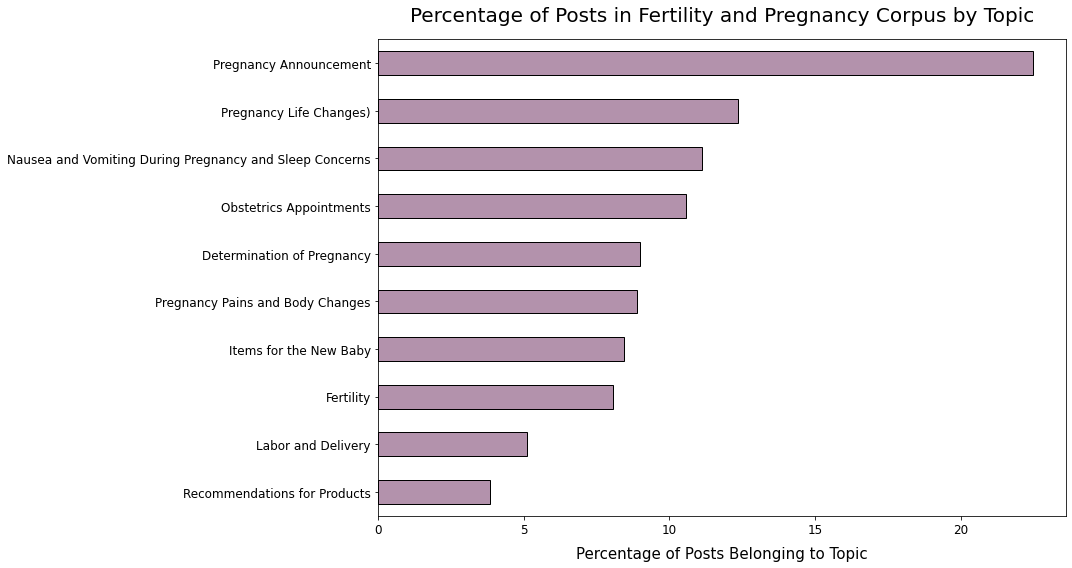

In [142]:
plot_topics_in_corpus(obsgyn_topic_df, 
                      'Dominant_Topic', 
                       medium_purple,
                       title = 'Percentage of Posts in Fertility and Pregnancy Corpus by Topic',
                       x_label = 'Percentage of Posts Belonging to Topic')

#### Postpartum Data

In [22]:
pospar_lda_model = build_gensim_lda(pospar_corpus, 
                               n_topics = 12, 
                               vocabulary = pospar_vocabulary, 
                               n_passes = 50)

In [23]:
build_gensim_coherence_model(pospar_lda_model, corpus = pospar_corpus, dictionary = pospar_vocabulary)

-1.992

<h4 align = center> Clusters Related to Maternal Health or Infant Development Concerns </h4>

| Cluster Number| Name| Top 5 Terms |
|:-:|:-:|:-:|
|0| Obstetrics Appointment| weight, ultrasound, doctor, baby, test|
|1| Baby's Sleeping and Feeding Schedule| sleep, nurse, night, feed, old|
|2| Labor and Delivery| labor, contraction, birth, baby, hospital|
|3|
|4| Determination of Pregnancy| period, test, pregnancy, pregnant, symptom|
|5| Breastfeeding (Pumping Supplies)| pump, bra, bag, spectra, breast|
|7| Pregnancy Life Changes| baby, work, shower, leave, family|
|8| Nausea and Vomiting During Pregnancy| eat, food, nausea, pregnancy, sickness|
|9| Breastfeeding (Process)| pump, milk, supply, breast, feed|
|10| Gender Reveal| boy, girl, gender, baby, group|
|11| Pregnancy Announcement| baby, pregnant, tell, husband, pregnancy|

| Cluster Number| Name| Top 5 Terms |
|:-:|:-:|:-:|
|6|Items to Buy for Baby| baby, buy, clothe, nursery, diaper|

From this data set, the following women's health or infant development concerns emerged. It is important to note that several concerns overlapped with concerns from the Fertility and Pregnancy data. 

* **Determination of Pregnancy**:

* **Pregnancy Announcement**:

* **Pregnancy Life Changes**:  

* **Obstetrics Appointment**: The top five terms for this topic are "weight", "ultrasound", "doctor", "baby", and test. Similar to the Fertility and Pregnancy data set, this topic has terms that describe procedures ("ultrasound", "test", "scan") and topics ("weight", "baby", "gain", "pregnancy", "blood", "result", "placenta", "heart", "healthy", "pound", "percentile" and "lose") that might be discussed at an appointment with the obstetrician. The words "OB" (obstetrician) and "appointment" further support this topic label.

* **Nausea and Vomiting During Pregnancy**:  

* **Gender Reveal**:  

* **Labor and Delivery**:  

* **Breastfeeding (Pumping Supplies)**:  

* **Breastfeeding (Process)**:  

* **Baby's Sleeping and Feeding Schedule**: The top five terms for this topic are "sleep", "nurse", "night", "feed", "old". Within this topic, there are several words related to the baby's sleep schedule ("sleep", "night", "wake", "asleep", "nap", "fall asleep") and to the process of feeding ("nurse", "feed", "wean", "breastfeed", "nursing", "boob", "eat", "feeding", "bite", "tooth", "bottle", "milk", "solids". It is possible that several posts within this topic address developing a sleeping and feeding schedule for the infant. Due to words such as "wean", "tooth", and "solid", it is also possible that this topic captures the transition the baby consuming from liquid foods (breastfeeding or bottle-feeding) to solid foods.


One topic was not directly related to maternal health or infant development concerns:  

* **Items to Buy for Baby**: The top five terms for this topic were "baby", "buy", "clothe", "nursery", and "diaper". These terms, along with words such as "crib", "registry", "item", "room", "need", "bassinet", "Amazon" suggest that this topic contains posts related to purchasing supplies for the baby.



In [157]:
get_topic_terms(pospar_lda_model, 12, 30)[1]

(1,
 '0.020*"sleep" + 0.017*"nurse" + 0.016*"night" + 0.016*"feed" + 0.015*"old" + 0.012*"wean" + 0.012*"breastfeed" + 0.011*"nursing" + 0.010*"boob" + 0.010*"wake" + 0.010*"hour" + 0.009*"baby" + 0.009*"eat" + 0.007*"start" + 0.007*"asleep" + 0.007*"try" + 0.007*"lo" + 0.007*"stop" + 0.006*"feeding" + 0.006*"bite" + 0.006*"nap" + 0.006*"tooth" + 0.006*"fall asleep" + 0.006*"fall" + 0.006*"bottle" + 0.006*"minute" + 0.005*"long" + 0.005*"cry" + 0.005*"milk" + 0.005*"solid"')

In [30]:
# pickle.dump(pospar_lda_model, open('../pickles/pospar_lda_model.p', 'wb'))

## Visualize Topics with pyLDAvis

### Create Gensim Dictionary

In [27]:
# https://stackoverflow.com/questions/21552518/using-scikit-learn-vectorizers-and-vocabularies-with-gensim

health_gensim_dict = Dictionary.from_corpus(corpus = health_corpus, id2word = health_vocabulary)
obsgyn_gensim_dict = Dictionary.from_corpus(corpus = obsgyn_corpus, id2word = obsgyn_vocabulary)
pospar_gensim_dict = Dictionary.from_corpus(corpus = pospar_corpus, id2word = pospar_vocabulary)

In [68]:
def display_pyLDAvis(model, corpus, gensim_dict):
    prepared = pyLDAvis.gensim.prepare(model, corpus, gensim_dict)
    display = pyLDAvis.display(prepared)
    return display

In [70]:
display_pyLDAvis(health_lda_model, health_corpus, health_gensim_dict)

In [96]:
display_pyLDAvis(obsgyn_lda_model, obsgyn_corpus, obsgyn_gensim_dict)

In [71]:
display_pyLDAvis(pospar_lda_model, pospar_corpus, pospar_gensim_dict)